<a href="https://colab.research.google.com/github/asangt/Portfolio-Management-of-Crypto-Assets/blob/master/Cryptoportfolio_management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portfolio Management of Crypto Assets

## Global imports

In [0]:
# General libraries for plotting, data preprocessing etc.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
import random

In [0]:
# Elements from torch library

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torch_data

seed = 0 # control seed

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # use gpu if available

In [61]:
# Check current GPU in Colab
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-3ad11459-d482-e3e1-53ca-7e6de98e94b9)


## LSTM Neural Network

In [0]:
class TEP(nn.Module):
    """
    Temporal embedding propagation algorithm from the paper "Temporal Relational
    Ranking" Feng et al. 2018.
    """

    def __init__(self, num_tokens):
        """
        Parameters:
          num_tokens - number of tokens
        """
        super(TEP, self).__init__()
        self.num_tokens = num_tokens
        self.eps = 1e-8

        self.linear = nn.Sequential(
                                    nn.Linear(self.num_tokens, self.num_tokens),
                                    nn.LeakyReLU(0.2)
                                   )

    def forward(self, seq_emb, graph_elems):
        """
        Parameters:
          seq_emb - sequential embedding tensor of size (batch_size, num_tokens, hidden_size)
          graph_elems - tuple, containing graph matrix A and number of token connections d
        Return:
          graph_emb - graph embedding of size (batch_size, num_tokens, hidden_size)
        """

        # create tensor of size (batch_size, num_tokens, hidden_size), which
        # will contain graph embeddings
        graph_emb = torch.zeros(seq_emb.size(), device=device)

        # read graph elems - graph matrix A and number of token connections d
        graph, d  = graph_elems

        for i in range(seq_emb.size(1)):
            # Eq. 12 from the paper
            similarity = torch.bmm(seq_emb, seq_emb[:,i,:].unsqueeze(2))
            relation_importance = self.linear(graph[:, :, i].unsqueeze(1)).permute(0, 2, 1)
            g = torch.mul(similarity, relation_importance)

            # Eq. 11 from the paper
            graph_emb[:,i,:] = torch.div(torch.matmul(g.permute(0, 2, 1), seq_emb), d[:, i].view(-1,1,1).repeat(1, 1, seq_emb.size(2))).squeeze(1)

        return graph_emb

In [0]:
class RankLSTM(nn.Module):
    """
    Ensemble of identical independent evaluators (EIIE) version of Rank LSTM from
    the paper "Temporal Relational Ranking" Feng et al. 2018. EIIE approach was suggested
    in "A Deep Reinforcement Learning Framework for the Financial Portfolio Management Problem"
    Jiang et al. 2017.
    """

    def __init__(self, input_size, hidden_size, output_size, num_series=1, relu_slope=0.15, dropout=0):
        """
        Parameters:
          input_size - number of input features,
          hidden_size - size of hidden dimension of LSTM,
          output_size - number of output features,
          num_series - number of tokens and identical independent evaluators,
          relu_slope - slope for the Leaky ReLU activation function,
          dropout - dropout probability
        """
        super(RankLSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.num_series = num_series
        self.negative_slope = relu_slope
        self.dropout = dropout
        self.eps = 1e-8
        
        # EIIE LSTM
        self.lstm = nn.ModuleList(
                                  [nn.LSTM(self.input_size, self.hidden_size, num_layers=1, batch_first=True) for i\
                                   in torch.arange(num_series, device=device)]
                                 )
        
        # Temporal Embedding Propagation
        self.tep  = TEP(self.num_series)

        # Fully connected output layer
        self.fc   = nn.Sequential(
                                  nn.Dropout(self.dropout),
                                  nn.Linear(2*self.hidden_size, self.output_size),
                                  nn.LeakyReLU(self.negative_slope)
                                 )

    def forward(self, x, graph_elems, verbose=False):
        """
        Perform forward pass through the network.
        Parameters:
          x - input price tensor of size (batch_size, num_series, window_size, num_features),
          graph_elems - tuple, containing graph matrix A and number of token connections d
        Return:
          ret - relational ranking of tokens \ their respective returns
        """

        # Pass x through EIIE LSTM stack
        lstm_outputs = []
        for layer in torch.arange(x.size(1), device=device):
            out, _ = self.lstm[layer](x[:, layer, :, :])
            lstm_outputs.append(out)
        lstm_outputs = torch.stack(lstm_outputs).permute(1, 0, 2, 3)

        # take only the last hidden state, eq. 7 from Feng et al. 2018
        seq_emb = lstm_outputs[:,:,-1,:]

        # pass through graph embedding algorithm
        graph_emb = self.tep(seq_emb, graph_elems)

        # concatenate sequential and graph embeddings
        seq_graph = torch.cat((seq_emb, graph_emb), axis=2)

        # pass through fully connected layer to get price prediction
        price_pred = self.fc(seq_graph).squeeze(2)

        # calculate ranking \ return
        ret = (price_pred - x[:,:,-1,0]) / (x[:,:,-1,0] + self.eps)

        return ret

    def train_epoch(self, criterion, optimizer, train_loader):
        """
        Perform one epoch training loop.
        Parameters:
          criterion - loss function,
          optimizer - optimizer,
          train_loader - data loader with training data
        Return:
          train_loss - accumulated training loss
        """
        self.train()

        train_loss = 0.
        for X, y, graph_elems in train_loader:
            # Perform one step of minibatch stochastic gradient descent
                    
            # send data to device
            X, y = X.to(device), y.to(device)

            # calculate outputs and loss
            y_pred = self.forward(X, graph_elems)
            loss   = criterion(y_pred, y)
            train_loss += loss.item()

            # update model weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        return train_loss

    def validate(self, criterion, val_loader):
        """
        Perform validation.
        Parameters:
          criterion - loss function,
          val_loader - data loader with validation dataset
        Return:
          val_loss - accumulated validation loss
        """
        self.eval()

        val_loss = 0.
        for X, y, graph_elems in val_loader:
            # Compute the validation loss
            X, y = X.to(device), y.to(device)

            y_pred    = self.forward(X, graph_elems)
            val_loss += criterion(y_pred, y).item()
       
        return val_loss

    def fit(self, epochs, criterion, optimizer, train_loader, val_loader=None, freq=None,\
            scheduler=None, stopping=None, verbose=False, save_dir=None):
        """
        Main training function.
        Parameters:
          epochs - number of training epochs,
          criterion - loss function,
          optimizer - optimizer,
          train_loader - data loader with training dataset,
          val_loader - data loader with validation dataset (default = None),
          freq - frequency of information outputs if verbose is True(default = None),
          scheduler - learning rate scheduler (default = None),
          stopping  - early stopping function (default = None),
          verbose - if True, output information messages about the training process (default = None),
          save_dir - if specified, denotes path to which save the model (default = None)
        """

        # if not specificed, take a default value
        if freq is None:
            freq = max(epochs // 10, 1)
        
        # lists of accumulated training and validation losses
        train_losses, val_losses = [], []

        # start timer
        start = time.time()
        for epoch in range(1, epochs+1):
            # train one epoch and save the training loss
            train_loss  = self.train_epoch(criterion, optimizer, train_loader)
            train_loss /= len(train_loader)
            train_losses.append(train_loss)

            # if validation loader is present, perform out of sample validation
            if val_loader is not None:
                val_loss  = self.validate(criterion, val_loader)
                val_loss /= len(val_loader)
                val_losses.append(val_loss)
            
            # if stopping criterion is specified, then check whether to break the
            # loop or not
            if stopping is not None and stopping.step(val_loss):
                break;

            # if learning rate scheduler is specified, then perform one step in it
            if scheduler is not None:
                scheduler.step()

            # if verbose is True, output training information
            if verbose and epoch%freq == 0:
                if val_loader is not None:
                    print('Epoch {}/{} || Loss:  Train {:f} | Validation {:f}'.\
                          format(epoch, epochs, train_loss, val_loss))
                else:
                    print('Epoch {}/{} || Loss:  Train {:f}'.format(epoch, epochs, train_loss))
        
        print('Elapsed time: {:f} s'.format(time.time() - start))

        # if verbose is True, output plot of training \ validation (if available) losses
        # evolution
        if verbose:
            plt.plot(np.arange(1, epochs+1), train_losses, label='Train loss', c='blue')
            if val_loader is not None:
                plt.plot(np.arange(1, epochs+1), val_losses, label='Val loss', c='red')
            plt.legend()
            plt.plot()

        # if save_dir is specified, save the model weights to PATH
        if save_dir is not None:
            torch.save(self.state_dict(), save_dir)

## Graph

In [7]:
# load temporal volume relations graph
A = np.load('data/Amatrix.npy')
for i in np.arange(A.shape[2]):
    A[:,:,i] += np.identity(A.shape[0])
A.shape

(25, 25, 24)

In [0]:
# calculate number of token interconnections for each token across all time windows
d = np.sum(A, axis=1)
d = d.reshape(-1, 24)

In [9]:
# convert to tensors and send to device
d = torch.tensor(d, dtype=torch.float, device=device)
A = torch.tensor(A, dtype=torch.float, device=device)
print(d.size(), A.size())

torch.Size([25, 24]) torch.Size([25, 25, 24])


## Load and preprocess data

In [0]:
# load dataset
X = np.load('data/best_25_hourly_2years.npy')
X = np.flip(X, axis=0)

In [0]:
# function to set timestamps for the respective time window in the temporal graph

def set_timestamps(data, n_periods=24):
    period = int(data.shape[0] / n_periods)
    data = np.concatenate((data, np.zeros(data.shape, dtype=int)), axis=2)
    for i in np.arange(n_periods):
        for t in np.arange(period):
            data[t + i*period,:,1] = i
    data[n_periods * period:, :, 1] = n_periods-1
    return data

In [0]:
# set timestamps on the data
stamped_data = set_timestamps(X)
stamped_data = np.flip(stamped_data, axis=2)
X = stamped_data

# put timestamps on top
X = np.flip(X, axis=2)

In [0]:
# plotting function
def plot_data(data, feature=0):
    fig, axes = plt.subplots(5, 5, figsize=(25, 10))
    timeline = np.arange(data.shape[0])

    for i in np.arange(5):
        for j in np.arange(5):
            axes[i,j].plot(timeline, data[:,i*5 + j, feature])
    plt.show()

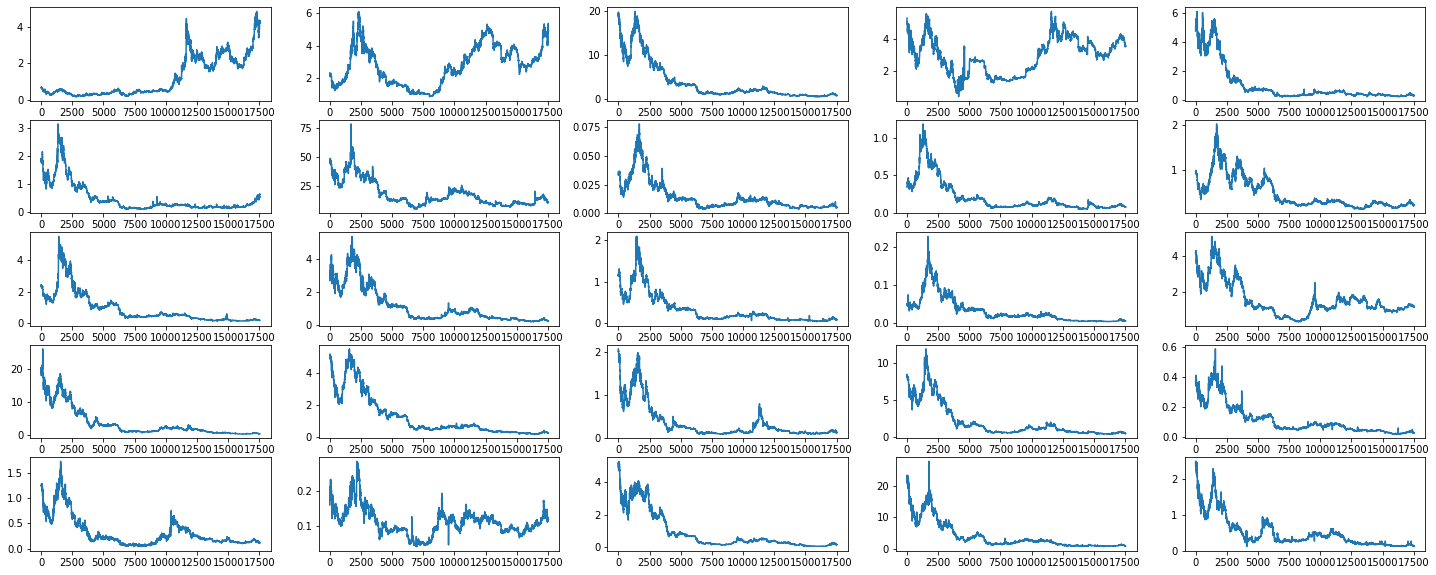

In [42]:
# plot initial data
plot_data(X, 0)

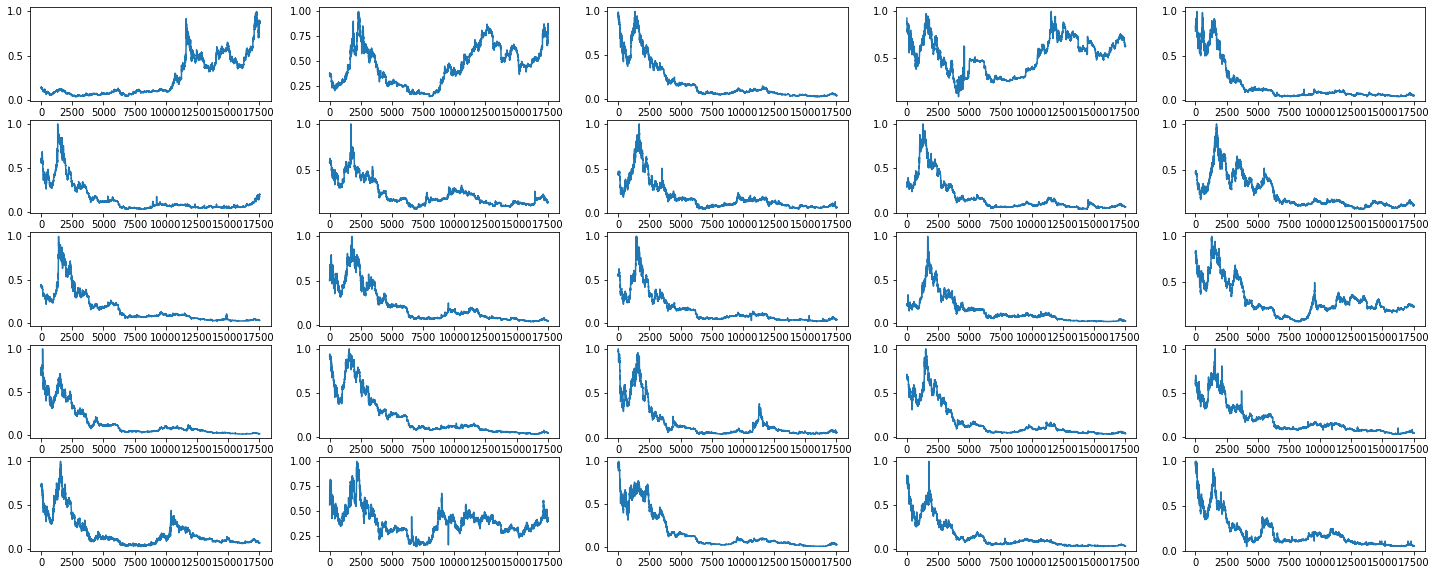

In [43]:
from sklearn.preprocessing import MaxAbsScaler

# scale data by dividing each token price history by its maximum value across
# the whole data set as per Feng et al. (2018)

scaler = MaxAbsScaler()
X[:, :, 0] = scaler.fit_transform(X[:, :, 0])

# plot scaled data
plot_data(X, 0)

In [0]:
# function to perform a sequential split of data
def sequential_split(data, train_split=0.7, val_split=None):
    if val_split is None:
        val_split = 0
    train_end = int(train_split * data.shape[0])
    val_end   = train_end + int(val_split * data.shape[0])

    return (data[:train_end], data[train_end:val_end], data[val_end:])

In [45]:
# train-test split
X_train, _, X_test = sequential_split(X, train_split=0.9, val_split=None)
print("Train shape", X_train.shape)
print("Test shape",  X_test.shape)

Train shape (15786, 25, 2)
Test shape (1754, 25, 2)


In [0]:
# calculate lookback moving averages, no future data is used to prevent leaking
# future information
def moving_averages(data, window_size):
    ma_list = []
    for i in np.arange(window_size):
        ma_list.append(np.mean(data[:i+1,:,0], axis=0))

    for i in np.arange(window_size, data.shape[0]):
        ma_list.append(np.mean(data[i - window_size:i,:,0], axis=0))

    return np.array(ma_list).reshape(-1, 25, 1)

In [47]:
# create additional features based on lookback moving averages,
# the purpose of them is to show denoised general trends of the past
# 12 and 24 hours

train_12, test_12 = moving_averages(X_train, window_size=12),\
                    moving_averages(X_test, window_size=12)

train_24, test_24 = moving_averages(X_train, window_size=24),\
                    moving_averages(X_test, window_size=24)                          

X_train = np.concatenate((X_train, train_12, train_24), axis=2)
X_test  = np.concatenate((X_test, test_12, test_24), axis=2)

# swap feature dimensions so that timestamps remain on top
train_tmp, test_tmp = X_train[:, :, 1].copy(), X_test[:, :, 1].copy()
X_train[:, :, 1], X_test[:, :, 1] = X_train[:, :, 3], X_test[:, :, 3]
X_train[:, :, 3], X_test[:, :, 3] = train_tmp, test_tmp

print(X_train[0, 0], X_test.shape)

[0.1367778 0.1367778 0.1367778 0.       ] (1754, 25, 4)


In [0]:
class CryptoData(torch_data.Dataset):
    """
    Dataset for the tokens.
    """

    def __init__(self, X, A, d, window_size=24, step_size=1, gap=1):
        """
        Parameters:
          X - input data tensor of size (n_samples, n_tokens, n_features),
          A - temporal graph of volume relations between tokens,
          d - number of connected tokens for column i in graph A (incl. connection of token with itself),
          window_size - size of a sliding lookback window (default = 24 hours),
          step_size   - number of timesteps ahead to forecast (default = 1 hour),
          gap         - gap between the sliding windows (default = 1 hour)
        """

        super(CryptoData, self).__init__()
        self.eps = 1e-8

        X_mod, y_mod, timestamps = [], [], []

        for i in torch.arange(window_size, X.shape[0] - step_size, gap):
            # create sliding windows and append them to X_mod
            X_mod.append(X[i-window_size:i,:,:-1])
            # append the target forecast for the sliding window above to y_mod
            y_mod.append((X[i+step_size-1,:,0] - X[i-1,:,0]) / (X[i-1,:,0] + self.eps))

            # take current timestamp as a last element from the lookback window,
            # this is needed to apply an appopriate time window for the temporal graph
            timestamps.append(X[i-1,:,-1])
        # convert lists into numpy arrays
        X_mod, y_mod, timestamps = np.array(X_mod), np.array(y_mod), np.array(timestamps)

        # reshape X_mod to be of size (n_samples, n_tokens, window_size, n_features)
        X_mod = X_mod.swapaxes(1,2)
        
        # initialize the dataset
        self.X = torch.tensor(X_mod, dtype=torch.float)
        self.y = torch.tensor(y_mod, dtype=torch.float)
        self.timestamps = torch.tensor(timestamps, dtype=torch.int)
        self.A = A
        self.d = d
    
    def __len__(self):
        # number of samples (sliding windows) in the dataset
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        # acquire timestamps of the slice idx
        t = self.timestamps[idx, 0].tolist()

        # if idx is a slice, then find timestamps for each element in a slice,
        # then create A and d of size (batch_size, n_tokens, n_tokens) and
        # (batch_size, n_tokens) respectively
        if not isinstance(t, int) and len(t) > 1:
            graph, d = [], []
            for i in range(len(t)):
                graph.append(self.A[:,:,t[i]])
                d.append(self.d[:,t[i]])
            graph, d = torch.stack(graph), torch.stack(d)
        else:
            # if idx is only a single integer, then just use the corresponding A and d
            graph, d = self.A[:,:,t], self.d[:,t]
        
        return self.X[idx], self.y[idx], (graph, d)

## Hyper parameter optimization and model validation

In [0]:
class EarlyStopping(object):
    """
    Early stopping class, which can be used to keep track of the best value of
    validation loss achieved and stop the training, if validation loss stops improving.
    """

    def __init__(self, patience=25, threshold=1e-4):
        """
        Parameters:
          patience  - how many epochs to wait without validation loss improvement over
                      the best achieved value until stopping the training loop,
          threshold - threshold between best achieved value of validation loss and new
                      values of validation loss
        """
        super(EarlyStopping, self).__init__()
        self.patience  = patience
        self.threshold = threshold

        # initialize parameters to keep track of best achieved validation loss score
        # and count number of epochs without improvement
        self.best       = None
        self.bad_epochs = None

    def step(self, val_loss):
        # get current loss value
        current_loss = float(val_loss)

        # check whether it is better, if True, then update best loss value and
        # nullify bad epochs counter, otherwise increment the bad epochs counter
        if self.best is None or current_loss < self.best * (1.0 - self.threshold):
            self.best = current_loss
            self.bad_epochs = 0
        else:
            self.bad_epochs +=1

        # return True and stop the training loop if patience limit is exceeded
        return True if self.bad_epochs > self.patience else False

In [0]:
class RankingAwareLoss(nn.Module):
    """
    Ranking aware loss function implementation from "Temporal Relational Ranking" Feng et al. 2018.
    """

    def __init__(self, alpha=0.1):
        """
        Parameters:
          alpha - variable which controls balance between mean squared error and rank loss
        """
        super(RankingAwareLoss, self).__init__()
        self.alpha = alpha

    def forward(self, y_pred, y):
        """
        Calculate loss.
        Parameters:
          y_pred - predicted return ratio,
          y - target return ratio
        Return:
          Ranking aware loss score
        """
        ones = torch.ones((y.size(0), y.size(1), 1), device=device)
        y_pairwise_diff = torch.matmul(y.unsqueeze(2), ones.permute(0, 2, 1)) - torch.matmul(ones, y.unsqueeze(1))
        y_pred_pairwise_diff = torch.matmul(ones, y_pred.unsqueeze(1)) - torch.matmul(y_pred.unsqueeze(2), ones.permute(0, 2, 1))
        #print(y_pred_pairwise_diff)

        return F.mse_loss(y_pred, y) + self.alpha * torch.mean(F.relu(torch.mul(y_pred_pairwise_diff, y_pairwise_diff)))

In [0]:
def walk_forward_CV(net, epochs, loss_function, criterion, optimizer, dataset, n_splits, window_size, batch_size=128):
    """
    Perform walk-forward cross validation. It is considered to be one of the most robust
    ways to assess performance of the model on time series data.
    Parameters:
      net - the network on which to perform cross validation,
      epochs - number of epochs to train the network before validating,
      loss_function - training loss function,
      criterion - cross validation assessment criterion,
      optimizer - optimizer,
      dataset - the training + validation dataset,
      n_splits - specifies into how many parts (sequential training + validation periods)
                 to split the dataset,
      window_size - time window size,
      batch_size  - batch size for the data loaders
    Return:
      total_loss  - average validation error over all splits,
      search_time - time spent on performing the walk-forward cross validation
    """

    # define number of splits and size of splits
    split_samples = dataset.__len__() // n_splits
    train_split   = math.ceil(0.8 * split_samples)
    val_split     = math.floor(0.2 * split_samples)

    # accumulated loss
    total_loss    = []

    # save initial model state in order to perform resets during CV
    reset_state = net.state_dict()

    start = time.time()
    for i in range(n_splits):
        # reset model weights for the new split
        net.load_state_dict(reset_state)
        net.to(device)

        # instantiate validation loss of the current split
        val_loss = 0.0

        # create train and val datasets depending on the current split
        train_set   = dataset[i*(train_split + val_split):(i+1)*train_split + i*val_split]
        val_set     = dataset[(i+1)*train_split + i*val_split:(i+1)*(train_split + val_split)]

        train_dset  = CryptoData(train_set, A, d, window_size=window_size, step_size=24)
        val_dset    = CryptoData(val_set, A, d, window_size=window_size, step_size=24)

        # insert them into the data loader
        train_loader = torch_data.DataLoader(train_dset, batch_size=batch_size, shuffle=True)
        val_loader   = torch_data.DataLoader(val_dset, batch_size=batch_size, shuffle=False)

        # train for specified number of epochs
        for epoch in range(1, epochs+1):
            net.train_epoch(loss_function, optimizer, train_loader)

        # calculate validation error
        val_error  = net.validate(criterion, val_loader)
        val_error /= len(val_loader)

        # append to the list of validation errors across all the splits
        total_loss.append(val_error)

    # fix search time
    search_time = time.time() - start

    total_loss  = np.array(total_loss)

    # take average across all the splits
    total_loss  = np.mean(total_loss)
        
    return total_loss, search_time

In [0]:
from itertools import product

def grid_search(parameters, train_set, verbose=False):
    """
    Perform grid search using walk-forward cross-validation to find optimal
    hyperparameters and validate the model against different time periods from
    the dataset.
    
    Parameters:
      parameters - list of hyper parameters through which the grid search will be performed,
      train_set  - dataset on which walk-forward CV will be performed,
      verbose - if True, then output live cross validation results
    Return:
      (best_params, best_error) - tuple containing best parameter set and its respective error score
    """

    # take all possible hyperparameter combinations as a list
    search_parameters = list(product(*parameters.values()))

    # initialize values for best error and corresponding best parameters for the model
    best_error, best_params = 1e6, None

    # initialize static values for the model
    input_size  = 3   # number of input features (closing prices, look-back moving averages for the past 12 and 24 hours)
    output_size = 1   # number of output features (predicted next 24 hours return ratio)
    num_series  = 25  # total number of tokens
    dropout     = 0.2 # dropout probability to combat overfitting
    slope       = 0.2 # LeakyReLU negative slope

    # perform grid search
    torch.manual_seed(seed) # to ensure reproducibility
    for comb in search_parameters:

        # initialize model with current parameters
        net = RankLSTM(input_size=input_size, hidden_size=comb[1], output_size=output_size,\
                       num_series=num_series, relu_slope=slope, dropout=0.1)
        
        # loss function and error criterion
        loss_function = RankingAwareLoss(comb[2])
        criterion = nn.L1Loss()

        # optimizer
        optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

        # take average model validation loss from the walk-forward CV
        model_error, search_time = walk_forward_CV(net, 15, loss_function, criterion, optimizer, train_set,\
                                                   window_size=comb[0], batch_size=comb[3], n_splits=5)
        
        # if True, output information about the searching process
        if verbose:
            print("Search time for combination", comb, "is", search_time, "s")
            print("Average validation error:", model_error)

        if best_error > model_error:
            best_error  = model_error
            best_params = comb
    
    return (best_params, best_error)

In [0]:
# set of parameters through which to search
parameters = {  
                "window_size" : [12, 24],
                "hidden_size" : [20, 30],
                "alpha" : [0.1, 1.0],
                "batch" : [64, 128]
             }

# perform grid search and save best parameters
best_params, best_error = grid_search(parameters, X_train, verbose=True)

Search time for combination (12, 20, 0.1, 64) is 180.279559135437 s
Average validation error: 0.14733857080340385
Search time for combination (12, 20, 0.1, 128) is 97.27510166168213 s
Average validation error: 0.17844371736049652
Search time for combination (12, 20, 1.0, 64) is 179.81140899658203 s
Average validation error: 0.1442821814119816
Search time for combination (12, 20, 1.0, 128) is 96.33557271957397 s
Average validation error: 0.163592549264431
Search time for combination (12, 30, 0.1, 64) is 176.35500693321228 s
Average validation error: 0.13307324431836604
Search time for combination (12, 30, 0.1, 128) is 94.81129789352417 s
Average validation error: 0.15777098655700683
Search time for combination (12, 30, 1.0, 64) is 175.3518717288971 s
Average validation error: 0.13902300894260405
Search time for combination (12, 30, 1.0, 128) is 94.32860493659973 s
Average validation error: 0.14863718688488006
Search time for combination (24, 20, 0.1, 64) is 200.0352339744568 s
Average v

In [0]:
print("best_params:", best_params, "best_error", best_error)

best_params: (12, 30, 0.1, 64) best_error 0.13307324431836604


## Train

In [0]:
# select window size according to the cross validation results
window_size = 12

train_dset = CryptoData(X_train, A, d, window_size, step_size=24)

In [0]:
# fix seed to ensure reproducibility
torch.manual_seed(seed)

# variables for the network, some of which are chosen based on CV results
batch_size = 64
input_size, output_size, num_series, slope = 3, 1, 25, 0.2
hidden_size, dropout = 20, 0.2

net = RankLSTM(input_size=input_size, hidden_size=hidden_size, output_size=output_size,\
               num_series=num_series, relu_slope=slope, dropout=dropout)

# uncomment to load model weight
#net.load_state_dict(torch.load('lstm_final.pth'))
#net.to(device)

# insantiate ranking aware loss function
criterion = RankingAwareLoss(0.1)

# early stopping criterion and optimizer
stopping  = None #EarlyStopping(patience=25)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

# lr scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.9)

# get data loader for the training set
train_loader = torch_data.DataLoader(train_dset, batch_size=batch_size, shuffle=True)

In [31]:
# perform training
net.to(device)
net.fit(250, criterion, optimizer, train_loader, None, 5, scheduler, stopping, True, 'lstm_test.pth')

RankLSTM(
  (lstm): ModuleList(
    (0): LSTM(3, 20, batch_first=True)
    (1): LSTM(3, 20, batch_first=True)
    (2): LSTM(3, 20, batch_first=True)
    (3): LSTM(3, 20, batch_first=True)
    (4): LSTM(3, 20, batch_first=True)
    (5): LSTM(3, 20, batch_first=True)
    (6): LSTM(3, 20, batch_first=True)
    (7): LSTM(3, 20, batch_first=True)
    (8): LSTM(3, 20, batch_first=True)
    (9): LSTM(3, 20, batch_first=True)
    (10): LSTM(3, 20, batch_first=True)
    (11): LSTM(3, 20, batch_first=True)
    (12): LSTM(3, 20, batch_first=True)
    (13): LSTM(3, 20, batch_first=True)
    (14): LSTM(3, 20, batch_first=True)
    (15): LSTM(3, 20, batch_first=True)
    (16): LSTM(3, 20, batch_first=True)
    (17): LSTM(3, 20, batch_first=True)
    (18): LSTM(3, 20, batch_first=True)
    (19): LSTM(3, 20, batch_first=True)
    (20): LSTM(3, 20, batch_first=True)
    (21): LSTM(3, 20, batch_first=True)
    (22): LSTM(3, 20, batch_first=True)
    (23): LSTM(3, 20, batch_first=True)
    (24): LSTM(3, 

In [49]:
# get testing dataset
test_dset = CryptoData(X_test, A, d, 12, 24, 24)
test_dset[:][0].size()

torch.Size([72, 25, 12, 3])

In [0]:
# get testing results
net.eval()

test_set  = test_dset[:][0].cpu().detach().numpy().copy()
test_pred = net(test_dset[:][0].to(device), test_dset[:][2]).cpu().detach().numpy().copy()
test_target = test_dset[:][1].cpu().detach().numpy().copy()

## Portfolio construction

In [0]:
import scipy.stats as stat
from ipywidgets import interact, FloatSlider

In [55]:
# load price history
X = np.load('data/best_25_hourly_2years.npy')
X = np.flip(X, axis=0)

# train-test split to mimic the one for NN
X_train, _, X_test = sequential_split(X, train_split=0.9, val_split=None)
print("Train shape", X_train.shape)
print("Test shape",  X_test.shape)

Train shape (15786, 25, 1)
Test shape (1754, 25, 1)


In [57]:
w_market_cap = np.load('w_market_cap.npy')
print(X_test.shape)
print(test_pred.shape)
print(X_train.shape)

(1754, 25, 1)
(72, 25)
(15786, 25, 1)


In [0]:
# this part of code was taken from https://towardsdatascience.com/python-markowitz-optimization-b5e1623060f5

def portfolio_annualised_performance(weights, mean_returns, cov_matrix, N):
    '''
    This function calculates returns and volatility of portfolio

    Parameters:
      weights - weights of portfoio
      mean_returns - mean returns of portfoio
      cov_matrix - covariance matrix
      N - number of trading points
    '''

    returns = np.sum(mean_returns*weights ) * N
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(N)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate, num_tokens, data):

    '''
    This function generates random portfoios 
    and calculare their return, volatility and Sharpe Ratio

    Parameters:
      num_portfolios - number of generated portfoios
      mean_returns - mean returns of portfoio
      cov_matrix - covariance matrix
      risk_free_rate - risk free rate
      num_tokens - number of tokens

    '''

    results = np.zeros((3,num_portfolios))
    weights_record = []
    
    for i in range(num_portfolios):

        weights = np.random.random(num_tokens)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix, data.shape[0])
        
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev

    return results, weights_record


def find_optimal_portfolios(mean_returns, cov_matrix, num_portfolios, risk_free_rate, data):

     # Generating random portfolios and storing their return, volatility and Sharpe Ratio
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate, data.shape[1], data)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    
    # find portfolios with maximal Sharpe Ratio and minimal volatility
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    b = max_sharpe_allocation
    max_sharpe_allocation = max_sharpe_allocation.T
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=data.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T

    return weights[min_vol_idx], weights[max_sharpe_idx]


def Mark(N):
    """
    This function returns two optimal portfolios, determined using Markowitz’s model 
    based on maximum Sharpe Ratio and minimum volatility

    Parameters:
      N - moment of time in wich portfolio weights are calculating
    """

    history_data = np.concatenate((X_train[:,:,:], X_test[:24*(N+1)-1 -12,:,:]), axis = 0)
    data = pd.DataFrame()
    for j in range(history_data.shape[1]):
        data = pd.concat([data, pd.DataFrame(history_data[:, j,:])], axis=1, sort=False)

    returns = data.pct_change()
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    N = data.shape[0]
    num_portfolios = 25000 # number of generating portfolios
    risk_free_rate = 0.039 # risk free rate was taken as risk free rate Bitcoin

    min_vol_allocation, max_sharpe_allocation = find_optimal_portfolios(mean_returns, cov_matrix, num_portfolios, risk_free_rate, data)

    return min_vol_allocation, max_sharpe_allocation

In [58]:
print(w_market_cap[170, :])

[1.11499968e-01 1.70996286e-01 3.68499728e-02 0.00000000e+00
 3.55381557e-04 6.07285645e-04 6.46096461e-01 7.00821611e-04
 1.43231542e-03 2.27522646e-03 2.01492125e-05 2.80327400e-04
 2.79328887e-04 4.48488352e-05 1.25584125e-02 1.92024864e-03
 1.17954260e-03 7.51084532e-04 6.72681937e-03 1.37825372e-06
 4.13914177e-03 1.24790553e-05 3.04534477e-04 6.38330299e-04
 3.29655517e-04]


In [0]:
def Black (time, N, t = 20):

    '''

    The Black-Litterman model is combining the expected returns of assets
    with the market equilibrium vector of expected returns 
    to form mixed estimate of expected returns

    Parameters:
      time - point in time at which the prediction is made
      N - number of assets in portfolio
      t - a scalar parameter that determines how to mix expected returns with the market’s view

    '''

    # generate historical data of prices and returns till the moment of prediction
    history_data = np.concatenate((X_train[:,:,:], X_test[:24*(time+1)-1 -12,:,:]), axis = 0)
    returns = []

    for i in range(int(history_data.shape[0]) - 1):
      returns.append((history_data[i+1, :, : ] - history_data[i-1, :, :]) / history_data[i-1, :, :])
    returns = np.array(returns)[:,:,0]
    mean_returns = returns.mean(0)
    cov_matrix = np.cov(returns.T) 

    # return that is expected at the next moment of time
    view_return = test_pred[time][:N]

    # market capitalization weight of the assets
    w_mrk = w_market_cap[24*(time+1)-1-12, :N]

    # Risk coefficient of market portfolio 
    risk = 1 / np.sqrt(w_mrk @ cov_matrix @ w_mrk.reshape(N,1))

    # generate a sample of excess returns
    excess_return = stat.multivariate_normal(returns.mean(0), cov_matrix).rvs(returns.shape[0])
    cov_excess = np.cov(excess_return.T)

    # Implied Equilibrium Return Vector
    P = risk * cov_excess @ w_mrk

    w_v = np.linalg.inv(risk * cov_excess) @ view_return.reshape(N,1)
    for i in range(len(w_v)):
      if w_v[i] < 0:
        w_v[i] = 0
    w_v = w_v / w_v.sum()


    cov_excess_inv = np.linalg.inv(cov_excess)
    cov_excess_inv_t = np.linalg.inv(t * cov_excess)
    return_bl = np.linalg.inv(cov_excess_inv_t + cov_excess_inv) @ ( cov_excess_inv_t @ P.reshape(N,1) + cov_excess_inv @ view_return.reshape(N,1))

    w_bl = np.linalg.inv(risk * cov_excess) @ return_bl

    for i in range(len(w_bl)):
      if w_bl[i] < 0:
        w_bl[i] = 0
    w_bl = w_bl/w_bl.sum()

    return w_v, w_mrk, w_bl.reshape(1,N)[0]

In [0]:
# In this cell we are plotting results
N = 25 # number of assets in portfolio

w_n = np.zeros(N) + 1/N # 1/N weights

# set initial portfolio value equal for each method
p0 = 1
mar, bl, mean, view, markw_SR, best, markw_vol = [p0], [p0], [p0], [p0], [p0], [p0], [p0]
bl_sum, mean_sum, mar_sum = [], [], []
S_bl, S_m, S_n, S_v = [], [], [], []
print(len(test_pred))
history_data = X_train[:,:,:]

ret_free = 0.039

for time in range(0, len(test_pred)):
    """
    test_pred[i] here is a prediction of return for X_test[24*(i+2)-13]
    12 - window size

    w_v - optimal weights to maximaze view return
    w_Bl - optimal weights for Black-Litterman model
    w_m - market capitalization weights
    
    w_markowitz_SR - weights with maximum Sharpe Ratio based on Markowitz model
    w_markowitz_Vol = weights with minimal volatility based on Markowitz model

    """

    w_v, w_m, w_Bl = Black(time, N, t = 0.1)  

    w_markowitz_Vol, w_markowitz_SR = Mark(time)

    w_markowitz_SR = w_markowitz_SR /100
    w_markowitz_Vol = w_markowitz_Vol /100

    w_b = np.zeros(N)
    best_idx = np.argmax(X_test[24*(time+1)-1 -12,:N,0] / X_test[24*(time)-1 -12,:N,0])
    w_b[best_idx] = 1

    bl.append((X_test[24*(time+2)-1 -12,:N,0] / X_test[24*(time+1)-1 -12,:N,0] @ w_Bl) * bl[time])
    mean.append((X_test[24*(time+2)-1-12,:N,0] / X_test[24*(time+1)-1-12,:N,0] @ w_n) * mean[time])
    mar.append((X_test[24*(time+2)-1 -12 ,:N,0] / X_test[24*(time+1)-1- 12,:N,0] @ w_m) * mar[time])
    view.append((X_test[24*(time+2)-1- 12,:N,0] / X_test[24*(time+1)-1 -12 ,:N,0] @ w_v) * view[time])
    best.append((X_test[24*(time+2)-1- 12,:N,0] / X_test[24*(time+1)-1 -12 ,:N,0] @ w_b) * best[time])


    markw_SR.append((X_test[24*(time+2)-1- 12,:N,0] / X_test[24*(time+1)-1 -12 ,:N,0] @ w_markowitz_SR) * markw_SR[time])
    markw_vol.append((X_test[24*(time+2)-1- 12,:N,0] / X_test[24*(time+1)-1 -12 ,:N,0] @ w_markowitz_Vol) * markw_vol[time])

    if time % 10 == 0:
      print("Time:", time)

bl = np.array(bl)/bl[0]
mean = np.array(mean)/mean[0]
mar = np.array(mar)/mar[0]
view = np.array(view)/view[0]
markw_SR = np.array(markw_SR)/markw_SR[0]
markw_vol = np.array(markw_vol)/markw_vol[0]
best = np.array(best)/best[0]

plt.figure(figsize = (10, 5))
plt.plot(bl, label = 'BL')
plt.plot(mean, label = '1/n')
plt.plot(view, label = 'NN')
plt.plot(mar, label = 'Market')
plt.plot(best, label = '1 Best')
plt.plot(markw_SR, label = 'markw_SR')
plt.plot(markw_vol, label = 'markw_vol')
plt.ylabel('Portfolio Value $p_t / p_0$')
plt.xlabel('Day')
plt.legend()
plt.title('Value')
plt.show()

In [0]:
# in this cell we calculatin Sharpe Ratio for each portfolio
# SR = (return of portfolio - risk free rate) / standard deviation of the portfolio’s excess return
# return of portfolio = (p_f - p_0) / p0


ret_free = 0.039 # risk free rate of Bitcoin

# calculating returns of each portfolio - risk free rate

ret_bl =  (bl[72] - bl[0]) / bl[0] - ret_free
ret_mean =  (mean[72] - mean[0]) / mean[0] - ret_free
ret_mar =  (mar[72] - mar[0]) / mar[0] - ret_free
ret_view =  (view[72] - view[0]) / view[0] - ret_free
ret_markw_SR =  (markw_SR[72] - markw_SR[0]) / markw_SR[0] - ret_free
ret_markw_vol =  (markw_vol[72] - markw_vol[0]) / markw_vol[0] - ret_free
ret_best =  (best[72] - best[0]) / best[0] - ret_free


# generating portfolio’s excess return and calculating its standard deviation

history_data = np.concatenate((history_data[:,:,:], X_test[:,:,:]), axis = 0)
returns = []
for i in range(int(history_data.shape[0]) - 1):
    returns.append((history_data[i+1, :, : ] - history_data[i-1, :, :]) / history_data[i-1, :, :])
returns = np.array(returns)[:,:,0]
mean_returns = returns.mean(0)
cov_matrix = np.cov(returns.T) 

excess_return = stat.multivariate_normal(returns.mean(0), cov_matrix).rvs(returns.shape[0])

ex_returns = returns - 0.039 
mean_returns = returns.mean(0)
std = np.std(excess_return)

print('Sharpe Ratio:')
print('BL:', (ret_bl /std  ))
print('Market:', ret_mar /std)
print('NN:', ret_view[0] /std)
print('1/n:', ret_mean /std)
print('1-Beast:', (ret_best /std  ))
print('Markowitz, min volatility:', ret_markw_vol /std)
print('Markowitz, max Sharpe Ratio:', ret_markw_SR /std)